# 1. Dataset Selection

In [1]:
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Read Parquet Example") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

# Read Parquet file
train_df = spark.read.parquet("/Users/ivantravisany/Documents/Estudios/git/medical-image-diagnosis-with-cnn/train-00000-of-00001-c08a401c53fe5312.parquet")
test_df = spark.read.parquet("/Users/ivantravisany/Documents/Estudios/git/medical-image-diagnosis-with-cnn/test-00000-of-00001-44110b9df98c5585.parquet")

24/12/13 01:48:12 WARN Utils: Your hostname, Ivans-MacBook-Pro-2.local resolves to a loopback address: 127.0.0.1; using 192.168.2.18 instead (on interface en0)
24/12/13 01:48:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/13 01:48:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Print schema
train_df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- bytes: binary (nullable = true)
 |    |-- path: string (nullable = true)
 |-- label: long (nullable = true)



In [3]:
# Show DataFrame content
train_df.show()

+--------------------+-----+
|               image|label|
+--------------------+-----+
|{[FF D8 FF E0 00 ...|    2|
|{[FF D8 FF E0 00 ...|    0|
|{[FF D8 FF E0 00 ...|    3|
|{[FF D8 FF E0 00 ...|    3|
|{[FF D8 FF E0 00 ...|    2|
|{[FF D8 FF E0 00 ...|    2|
|{[FF D8 FF E0 00 ...|    2|
|{[FF D8 FF E0 00 ...|    2|
|{[FF D8 FF E0 00 ...|    3|
|{[FF D8 FF E0 00 ...|    2|
|{[FF D8 FF E0 00 ...|    2|
|{[FF D8 FF E0 00 ...|    1|
|{[FF D8 FF E0 00 ...|    2|
|{[FF D8 FF E0 00 ...|    3|
|{[FF D8 FF E0 00 ...|    2|
|{[FF D8 FF E0 00 ...|    3|
|{[FF D8 FF E0 00 ...|    3|
|{[FF D8 FF E0 00 ...|    0|
|{[FF D8 FF E0 00 ...|    3|
|{[FF D8 FF E0 00 ...|    2|
+--------------------+-----+
only showing top 20 rows



# 2. Data Cleaning

## 2.1. Check for Missing Values

In [4]:
# Count missing values
from pyspark.sql.functions import col

missing_image_count = train_df.filter(col("image").isNull()).count()
missing_label_count = train_df.filter(col("label").isNull()).count()

print(f"Train DF\nMissing images: {missing_image_count}, Missing labels: {missing_label_count}")

Train DF
Missing images: 0, Missing labels: 0


In [5]:
missing_image_count = test_df.filter(col("image").isNull()).count()
missing_label_count = test_df.filter(col("label").isNull()).count()

print(f"Test DF\nMissing images: {missing_image_count}, Missing labels: {missing_label_count}")

Test DF
Missing images: 0, Missing labels: 0


## 2.2. Handle Outliers

In [6]:
# Count out-of-range labels
outlier_count_train = train_df.filter((col("label") < 0) | (col("label") > 3)).count()
print(f"Train Outlier labels: {outlier_count_train}")

# Remove rows with out-of-range labels
train_df_cleaned = train_df.filter((col("label") >= 0) & (col("label") <= 3))

Train Outlier labels: 0


In [7]:
# Count out-of-range labels
outlier_count_test = test_df.filter((col("label") < 0) | (col("label") > 3)).count()
print(f"Test Outlier labels: {outlier_count_test}")

# Remove rows with out-of-range labels
test_df_cleaned = test_df.filter((col("label") >= 0) & (col("label") <= 3))

Test Outlier labels: 0


## 2.3. Verify and Clean Image Column

In [8]:
# Check for invalid `image` format
train_invalid_images = train_df_cleaned.filter(col("image").isNull()).count()
print(f"Invalid train image rows: {train_invalid_images}")

Invalid train image rows: 0


In [9]:
# Check for invalid `image` format
test_invalid_images = test_df_cleaned.filter(col("image").isNull()).count()
print(f"Invalid test image rows: {test_invalid_images}")

Invalid test image rows: 0


## 2.4. Ensure Dataframe Readiness

In [10]:
# Display schema
train_df_cleaned.printSchema()

print("Train DF")
# Data distribution for labels
train_df_cleaned.groupBy("label").count().show()

print("Test DF")
# Data distribution for labels
test_df_cleaned.groupBy("label").count().show()

root
 |-- image: struct (nullable = true)
 |    |-- bytes: binary (nullable = true)
 |    |-- path: string (nullable = true)
 |-- label: long (nullable = true)

Train DF
+-----+-----+
|label|count|
+-----+-----+
|    0|  724|
|    1|   49|
|    3| 1781|
|    2| 2566|
+-----+-----+

Test DF
+-----+-----+
|label|count|
+-----+-----+
|    0|  172|
|    1|   15|
|    3|  459|
|    2|  634|
+-----+-----+



# 3. Data Exploration

In [11]:
# Summary statistics for the label column
train_df_cleaned.describe("label").show()

+-------+------------------+
|summary|             label|
+-------+------------------+
|  count|              5120|
|   mean|        2.05546875|
| stddev|0.9592443951012233|
|    min|                 0|
|    max|                 3|
+-------+------------------+



**Label Distribution**

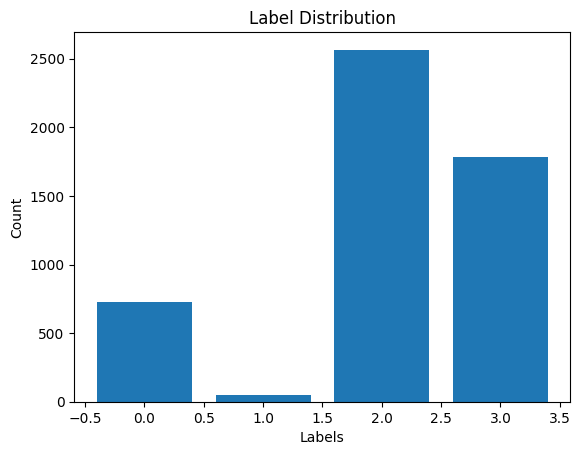

In [12]:
import matplotlib.pyplot as plt

# Convert label distribution to Pandas
label_distribution = train_df_cleaned.groupBy("label").count().toPandas()

# Plot the distribution
plt.bar(label_distribution["label"], label_distribution["count"])
plt.title("Label Distribution")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.show()

**Image Length/Size Col**

In [13]:
from pyspark.sql.functions import length, col

# Extract the `bytes` field and calculate its length
train_df_cleaned = train_df_cleaned.withColumn("image_length", length(col("image.bytes")))

# Summary statistics for image lengths
train_df_cleaned.describe("image_length").show()

# Show the updated DataFrame
train_df_cleaned.select("image_length", "label").show()

+-------+------------------+
|summary|      image_length|
+-------+------------------+
|  count|              5120|
|   mean|    4392.105078125|
| stddev|249.58618592683132|
|    min|              3343|
|    max|              4947|
+-------+------------------+

+------------+-----+
|image_length|label|
+------------+-----+
|        3534|    2|
|        4673|    0|
|        4411|    3|
|        4193|    3|
|        4391|    2|
|        4608|    2|
|        4725|    2|
|        4125|    2|
|        4499|    3|
|        4011|    2|
|        4220|    2|
|        4504|    1|
|        4695|    2|
|        4566|    3|
|        4511|    2|
|        4207|    3|
|        4376|    3|
|        4801|    0|
|        4728|    3|
|        4712|    2|
+------------+-----+
only showing top 20 rows



In [14]:
# Compute correlations
correlation = train_df_cleaned.stat.corr("image_length", "label")
print(f"Correlation between image_length and label: {correlation}")

Correlation between image_length and label: -0.03428947317714483


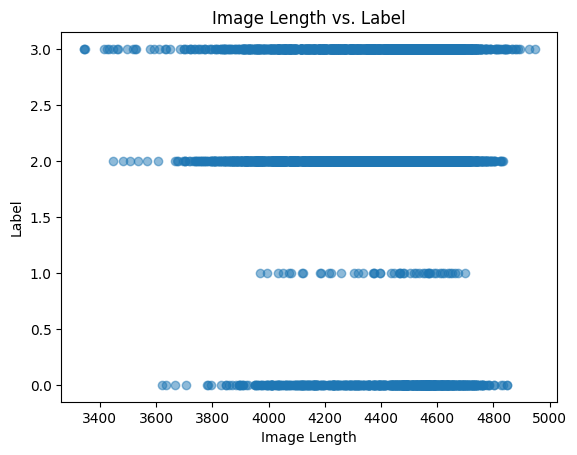

In [15]:
# Collect data for visualization
scatter_data = train_df_cleaned.select("image_length", "label").toPandas()

# Plot scatter plot
plt.scatter(scatter_data["image_length"], scatter_data["label"], alpha=0.5)
plt.title("Image Length vs. Label")
plt.xlabel("Image Length")
plt.ylabel("Label")
plt.show()

**Actual Images**

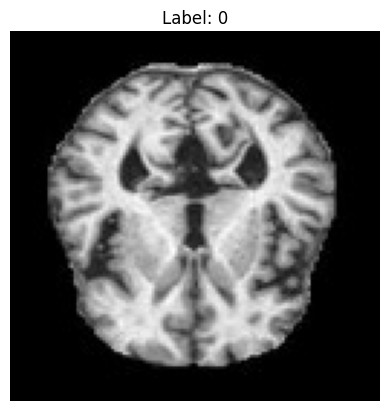

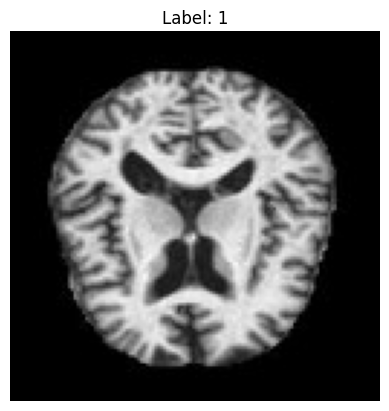

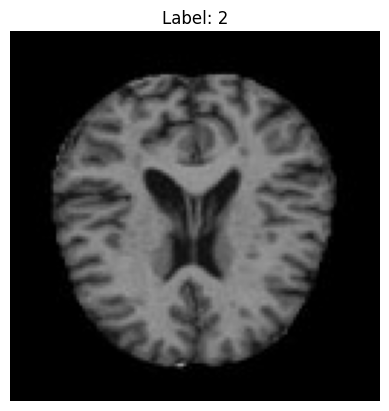

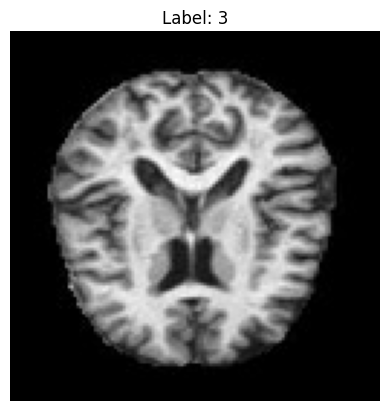

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import first

# Select one example per label
sampled_data = (
    train_df_cleaned.groupBy("label")
    .agg(first("image.bytes").alias("bytes"))  # Alias the aggregated column
    .collect()
)

# Iterate over the rows and visualize each image
for row in sampled_data:
    image_bytes = row["bytes"]  # Extract binary data
    label = row["label"]        # Extract the label

    # Convert binary data to a NumPy array
    image_array = np.frombuffer(image_bytes, dtype=np.uint8)
    
    # Decode the image using OpenCV
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    if image is None:
        print(f"Failed to decode image for label: {label}")
        continue
    
    # Convert BGR (OpenCV format) to RGB for matplotlib
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.figure()
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.axis("off")
    plt.show()

# 4. Feature Engineering

## 4.1. New Features from Extracted Metadata

**Image Size**

In [17]:
from pyspark.sql.functions import length

# Extract image size in bytes
df_features = train_df_cleaned.withColumn("image_size", length("image.bytes"))

**Mean Pixel Intensity**

In [18]:
import cv2
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

# Define UDF for mean pixel intensity using OpenCV
def extract_mean_intensity(image_bytes):
    try:
        # Convert the binary data into an image using OpenCV
        image_array = bytearray(image_bytes)  # Convert to a mutable sequence of bytes
        image = cv2.imdecode((image_array), cv2.IMREAD_GRAYSCALE)  # Load as grayscale
        
        if image is not None:
            # Use OpenCV's mean function to compute the mean intensity
            mean_intensity = cv2.mean(image)[0]  # cv2.mean returns a tuple; the first value is the mean
            return float(mean_intensity)
        else:
            return None
    except Exception:
        return None

mean_intensity_udf = udf(extract_mean_intensity, DoubleType())

# Apply UDF to extract mean intensity
df_features = df_features.withColumn("mean_intensity", mean_intensity_udf("image.bytes"))

**St. Dev. of Pixel Intensity**

In [19]:
import cv2
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

def extract_std_intensity(image_bytes):
    try:
        # Convert the binary data into an image using OpenCV
        # First, we must have a bytes-like object for imdecode:
        # image_bytes is already bytes, so we can directly pass it to imdecode after making it a 1D array.
        # However, imdecode expects a numpy array. To avoid numpy calls here, we rely on OpenCV’s internal usage.
        
        # Even though OpenCV uses NumPy internally, we’re not calling NumPy functions ourselves.
        # Just ensure that `image_bytes` is transformed into a byte array suitable for imdecode.
        image_array = bytearray(image_bytes)  # Convert to a mutable sequence of bytes
        image_mat = cv2.imdecode((image_array), cv2.IMREAD_GRAYSCALE)
        
        if image_mat is not None:
            # Use OpenCV's meanStdDev to compute standard deviation
            mean, stddev = cv2.meanStdDev(image_mat)
            # mean and stddev are returned as arrays of shape (1,1), extract the single element
            return float(stddev[0][0])
        else:
            return None
    except Exception:
        return None

std_intensity_udf = udf(extract_std_intensity, DoubleType())

# Apply UDF to extract standard deviation of pixel intensity
df_features = df_features.withColumn("std_intensity", std_intensity_udf("image.bytes"))

**Color Histogram Features**

In [20]:
'''
from pyspark.sql.types import ArrayType

# Define UDF for color histogram
def extract_color_histogram(image_bytes, bins=16):
    try:
        image = Image.open(io.BytesIO(image_bytes))
        image = image.convert("RGB")  # Ensure image is in RGB format
        histograms = []
        for channel in range(3):  # R, G, B
            histograms.extend(image.histogram()[channel * 256:(channel + 1) * 256][::256 // bins])
        return histograms
    except:
        return None

color_histogram_udf = udf(lambda x: extract_color_histogram(x), ArrayType(DoubleType()))

# Apply UDF to extract color histograms
df_features = df_features.withColumn("color_histogram", color_histogram_udf("image.bytes"))
'''

'\nfrom pyspark.sql.types import ArrayType\n\n# Define UDF for color histogram\ndef extract_color_histogram(image_bytes, bins=16):\n    try:\n        image = Image.open(io.BytesIO(image_bytes))\n        image = image.convert("RGB")  # Ensure image is in RGB format\n        histograms = []\n        for channel in range(3):  # R, G, B\n            histograms.extend(image.histogram()[channel * 256:(channel + 1) * 256][::256 // bins])\n        return histograms\n    except:\n        return None\n\ncolor_histogram_udf = udf(lambda x: extract_color_histogram(x), ArrayType(DoubleType()))\n\n# Apply UDF to extract color histograms\ndf_features = df_features.withColumn("color_histogram", color_histogram_udf("image.bytes"))\n'

**Final schema**

In [21]:
df_features.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- bytes: binary (nullable = true)
 |    |-- path: string (nullable = true)
 |-- label: long (nullable = true)
 |-- image_length: integer (nullable = true)
 |-- image_size: integer (nullable = true)
 |-- mean_intensity: double (nullable = true)
 |-- std_intensity: double (nullable = true)



## 4.2. Normalize Features

In [24]:
import statistics
from pyspark.sql.functions import col, min as spark_min, max as spark_max
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import udf

# UDF to compute mean intensity assuming image.bytes is raw grayscale data
def extract_mean_intensity(image_bytes):
    try:
        pixel_values = list(image_bytes)  # Each byte is a pixel intensity [0-255]
        mean_val = statistics.mean(pixel_values)
        return float(mean_val)
    except:
        return None

mean_intensity_udf = udf(extract_mean_intensity, DoubleType())
df_features = df_features.withColumn("mean_intensity", mean_intensity_udf("image.bytes"))

# UDF to compute standard deviation of pixel intensity
def extract_std_intensity(image_bytes):
    try:
        pixel_values = list(image_bytes)
        # Use population standard deviation (pstdev) or sample std depending on your need
        stdev_val = statistics.pstdev(pixel_values)
        return float(stdev_val)
    except:
        return None

std_intensity_udf = udf(extract_std_intensity, DoubleType())
df_features = df_features.withColumn("std_intensity", std_intensity_udf("image.bytes"))

# Now normalize the features: image_size, mean_intensity, std_intensity
features_to_normalize = ["image_size", "mean_intensity", "std_intensity"]

for feature in features_to_normalize:
    feature_min = df_features.select(spark_min(col(feature))).first()[0]
    feature_max = df_features.select(spark_max(col(feature))).first()[0]
    
    # Add a normalized column using min-max normalization
    df_features = df_features.withColumn(
        f"{feature}_normalized",
        (col(feature) - feature_min) / (feature_max - feature_min)
    )

# Optionally, drop the original columns
df_features = df_features.drop(*features_to_normalize)

df_features.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# 5. Model Selection

In [25]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# 1. Assemble features into a vector
assembler = VectorAssembler(
    inputCols=["image_size_normalized", "mean_intensity_normalized", "std_intensity_normalized"],
    outputCol="features"
)
df_prepared = assembler.transform(df_features)

# Split into training and test sets
train_data, test_data = df_prepared.randomSplit([0.8, 0.2], seed=42)

# 2. Train Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_data)

# Make predictions with Logistic Regression
lr_predictions = lr_model.transform(test_data)

# Evaluate Logistic Regression
lr_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
lr_accuracy = lr_evaluator.evaluate(lr_predictions)
print(f"Logistic Regression Test Accuracy: {lr_accuracy:.2f}")

# 3. Train Random Forest Classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100)
rf_model = rf.fit(train_data)

# Make predictions with Random Forest
rf_predictions = rf_model.transform(test_data)

# Evaluate Random Forest
rf_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
rf_accuracy = rf_evaluator.evaluate(rf_predictions)
print(f"Random Forest Test Accuracy: {rf_accuracy:.2f}")

24/12/13 01:53:23 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Logistic Regression Test Accuracy: 0.52


Random Forest Test Accuracy: 0.51


# 6. Hyperparameter Tuning

In [27]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Assemble features into a vector
assembler = VectorAssembler(
    inputCols=["image_size_normalized", "mean_intensity_normalized", "std_intensity_normalized"],
    outputCol="features"
)
df_prepared = assembler.transform(df_features)

# Split into training and test
train_data, test_data = df_prepared.randomSplit([0.8, 0.2], seed=42)

# Logistic Regression Tuning
lr = LogisticRegression(featuresCol="features", labelCol="label")
lr_param_grid = (ParamGridBuilder()
                 .addGrid(lr.regParam, [0.1, 0.01])
                 .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
                 .build())

lr_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=lr_param_grid, evaluator=lr_evaluator, numFolds=3)
lr_cv_model = lr_cv.fit(train_data)
best_lr_model = lr_cv_model.bestModel

# Random Forest Tuning
rf = RandomForestClassifier(featuresCol="features", labelCol="label", seed=42)
rf_param_grid = (ParamGridBuilder()
                 .addGrid(rf.numTrees, [50, 100])
                 .addGrid(rf.maxDepth, [5, 10])
                 .build())

rf_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
rf_cv = CrossValidator(estimator=rf, estimatorParamMaps=rf_param_grid, evaluator=rf_evaluator, numFolds=3)
rf_cv_model = rf_cv.fit(train_data)
best_rf_model = rf_cv_model.bestModel

# Evaluate best models
lr_accuracy = lr_evaluator.evaluate(best_lr_model.transform(test_data))
rf_accuracy = rf_evaluator.evaluate(best_rf_model.transform(test_data))

print(f"Best Logistic Regression Accuracy: {lr_accuracy:.2f}")
print(f"Best Random Forest Accuracy: {rf_accuracy:.2f}")

24/12/13 02:00:11 WARN DAGScheduler: Broadcasting large task binary with size 1544.3 KiB
24/12/13 02:00:12 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/12/13 02:00:12 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/12/13 02:00:13 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/12/13 02:00:16 WARN DAGScheduler: Broadcasting large task binary with size 1032.1 KiB
24/12/13 02:00:16 WARN DAGScheduler: Broadcasting large task binary with size 1764.6 KiB
24/12/13 02:00:16 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/12/13 02:00:17 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/12/13 02:00:17 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
24/12/13 02:00:18 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/12/13 02:00:42 WARN DAGScheduler: Broadcasting large task binary with size 1540.3 KiB
24/12/13 02:00:42 WARN DAGScheduler: Broad

Best Logistic Regression Accuracy: 0.52
Best Random Forest Accuracy: 0.51


# 7. Pickle Files

I had several errors because PySpark models cannot be directly pickled due to their dependencies on the JVM and internal thread locks. To address this, I needed to save the model using PySpark’s built-in saving mechanism

In [ ]:
# Save the best Logistic Regression model
best_lr_model.save("best_lr_model")

# Save the best Random Forest model
best_rf_model.save("best_rf_model")